In [2]:
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [3]:
def generate_signals(data, short_ewma_span, long_ewma_span):
    # Load data (replace with your actual data)
    data['short_ewma'] = data['close'].ewm(span=short_ewma_span, adjust=False).mean()
    data['long_ewma'] = data['close'].ewm(span=long_ewma_span, adjust=False).mean()

    # Generate signals
    data['signal'] = 0
    data.loc[data['short_ewma'] > data['long_ewma'], 'signal'] = 1  # Buy signal
    data.loc[data['short_ewma'] < data['long_ewma'], 'signal'] = -1  # Sell signal
    return data

# Function to execute trades
def execute_trades(data, initial_account_value, buying_power):
    account_value = initial_account_value
    positions = 0
    cash = initial_account_value
    remaining_buying_power = buying_power
    trade_log = []

    for timestamp, row in data.iterrows():
        price = row['close']
        signal = row['signal']

        # Liquidate at the end of the day
        if timestamp.time() >= pd.Timestamp('14:55:00').time():
            if positions != 0:
                cash += positions * price
                account_value = cash
                remaining_buying_power = 2 * account_value
                trade_log.append({'timestamp': timestamp, 'action': 'liquidate', 'price': price, 'positions': positions})
                positions = 0
            continue

        # Buy signal
        if signal == 1:
            quantity = (0.2*remaining_buying_power) // price  # Buy 20% of remaining buying power
            cost = quantity * price
            cash -= cost
            positions += quantity
            account_value = cash + (positions * price)
            remaining_buying_power -=  cost
            trade_log.append({'timestamp': timestamp, 'action': 'buy', 'price': price, 'quantity': quantity})

        # Sell signal
        elif signal == -1:
            quantity = math.floor(0.2*positions)  # Sell 20% of current position
            cash += (quantity * price)
            positions -= quantity
            account_value = cash + (positions * price)
            remaining_buying_power += (quantity * price)
            trade_log.append({'timestamp': timestamp, 'action': 'sell', 'price': price, 'quantity': quantity})

    return pd.DataFrame(trade_log), account_value, buying_power

In [ ]:
# Sample parameters
short_ewma_span = 5  # Short EWMA span in minutes
long_ewma_span = 20  # Long EWMA span in minutes
initial_account_value = 100_000
buying_power = 200_000  # Buying power (includes margin)

# Load data
directory_path = '/Users/amylee/Desktop/Financial Computing/Project/p4/data/TSLA'
files = os.listdir(directory_path)

account_value = 100000  # initial account value
buying_power = 200_000  # initial buying power

daily_account_values = pd.DataFrame(columns=['date', 'account_value', 'buying_power'])

# Iterate through each file and execute trades
for file in files:
    data = pd.read_parquet(os.path.join(directory_path, file))
    data = generate_signals(data, short_ewma_span, long_ewma_span)
    date = file.split('_')[1].split('.')[0]
    # Execute trades and update account value and buying power
    trade_log, av, bp = execute_trades(data=data, initial_account_value=account_value, buying_power=buying_power)
    # Save the trade log
    trade_log.to_parquet(f"/Users/amylee/Desktop/Financial Computing/Project/p4/trade_logs/trade_log_{file}")
    # Save the daily account value and buying power
    daily_account_values = pd.concat([daily_account_values,
                                      pd.DataFrame({'date': [date], 'account_value': [av], 'buying_power': [bp]})])
    # Update initial_account_value for the next iteration
    account_value = av
    buying_power = bp
    
# Calculate daily returns and cumulative returns
daily_account_values['date'] = pd.to_datetime(daily_account_values['date'])
daily_account_values = daily_account_values.reset_index(drop=True).set_index('date')
daily_account_values = daily_account_values.sort_index()
daily_account_values['daily_return'] = daily_account_values['account_value'].pct_change()
daily_account_values['cumulative_return'] = (1 + daily_account_values['daily_return']).cumprod() - 1

/var/folders/k8/508x1ykn4h9bfqn3c5rmf7n00000gn/T/ipykernel_33497/1954331734.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  daily_account_values = pd.concat([daily_account_values,


In [ ]:
# Calculate Sharpe ratio
daily_account_values['daily_return'].mean() / daily_account_values['daily_return'].std() * math.sqrt(252)

np.float64(1.3157450760974518)

<Axes: xlabel='date'>

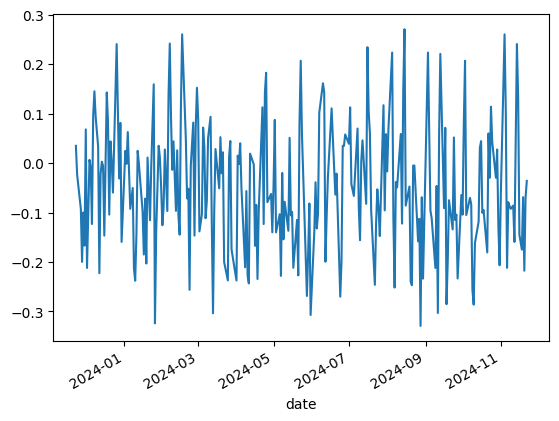

In [ ]:
# Plot cumulative return
daily_account_values['cumulative_return'].plot()